In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#import xesmf as xe
import os
import gsw
import time
import datetime

In [2]:
# FIRST WE LOAD THE MODEL DATA
# We load first temperature data (in a regular grid)
simT = xr.open_mfdataset(("/esarchive/exp/ecearth/a247/diags/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r2i1p1f1/Omon/thetao/r360x180/v20200120/thetao_Omon_EC-Earth3_historical_r2i1p1f1_r360x180_19*.nc"))
# And now salinity data (in a regular grid)
simS = xr.open_mfdataset(("/esarchive/exp/ecearth/a247/diags/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r2i1p1f1/Omon/so/r360x180/v20200120/so_Omon_EC-Earth3_historical_r2i1p1f1_r360x180_19*.nc"))
# WE LOAD TWO OBS CLIMATOLOGIES NOW JUST AFTERWARDS (this would require copying the data across to Levante)
#obsTfiles = ["/esarchive/obs/ukmo/en4-v4.2.2_g10/monthly_mean/thetao/"+"thetao_"+str(year)+"*.nc" for year in range(1950, 2021)]
#obsSfiles = ["/esarchive/obs/ukmo/en4-v4.2.2_g10/monthly_mean/so/"+"so_"+str(year)+"*.nc" for year in range(1950, 2021)]
#obsT = xr.open_mfdataset(obsTfiles)
#obsS = xr.open_mfdataset(obsSfiles)
obsT = xr.open_mfdataset(("/esarchive/scratch/portega/de_tests/EN4-AQUA-Clims/thetao-en4-v2.2.2-clim-1950_1980.nc"))
obsS = xr.open_mfdataset(("/esarchive/scratch/portega/de_tests/EN4-AQUA-Clims/so-en4-v2.2.2-clim-1950_1980.nc"))
#obsT = xr.open_mfdataset(("/esarchive/obs/ukmo/en4-v4.2.2_g10/monthly_mean/so/so_\{1950..2020\}*.nc"))

In [3]:
# We produce weights (for the regular grid)
weights=np.cos(np.deg2rad(simT.latitude)) # Weights are proportional to the grid cell area, which is influenced by the latitudes
oweights=np.cos(np.deg2rad(obsT.lat))

In [4]:
# Here we compute the density values at 0 level. For that we use the Equation of State that requires absolute salinity and conservative temperature as inputs
# First we introduce a function to convert practical salinity to absolute salinity
def convert_so(so):
    """
    Convert practical salinity to absolute.

    Parameters
    ----------
    so: dask.array.core.Array
        Masked array containing the practical salinity values (psu or 0.001).

    Returns
    -------
    absso: dask.array.core.Array
        Masked array containing the absolute salinity values (g/kg).

    Note
    ----
    This function use an approximation from TEOS-10 equations and could
    lead to different values in particular in the Baltic Seas.
    http://www.teos-10.org/pubs/gsw/pdf/SA_from_SP.pdf

    """
    return so / 0.99530670233846
# And we compute absolute salinity 
obsSa=convert_so(obsS.so)
simSa=convert_so(simS.so)

In [5]:
# Here we introduce a function to convert potential temperature to conservative temperature
def convert_thetao(absso, thetao):
    """
    Parameters
    ----------
    absso: dask.array.core.Array
        Masked array containing the absolute salinity values.
    thetao: dask.array.core.Array
        Masked array containing the potential temperature values (degC).

    Returns
    -------
    bigthetao: dask.array.core.Array
        Masked array containing the conservative temperature values (degC).

    Note
    ----
    http://www.teos-10.org/pubs/gsw/html/gsw_CT_from_pt.html

    """
    x = np.sqrt(0.0248826675584615*absso)
    y = thetao*0.025e0
    enthalpy = 61.01362420681071e0 + y*(168776.46138048015e0 +
        y*(-2735.2785605119625e0 + y*(2574.2164453821433e0 +
        y*(-1536.6644434977543e0 + y*(545.7340497931629e0 +
        (-50.91091728474331e0 - 18.30489878927802e0*y)*
        y))))) + x**2*(268.5520265845071e0 + y*(-12019.028203559312e0 +
        y*(3734.858026725145e0 + y*(-2046.7671145057618e0 +
        y*(465.28655623826234e0 + (-0.6370820302376359e0 -
        10.650848542359153e0*y)*y)))) +
        x*(937.2099110620707e0 + y*(588.1802812170108e0+
        y*(248.39476522971285e0 + (-3.871557904936333e0-
        2.6268019854268356e0*y)*y)) +
        x*(-1687.914374187449e0 + x*(246.9598888781377e0 +
        x*(123.59576582457964e0 - 48.5891069025409e0*x)) +
        y*(936.3206544460336e0 +
        y*(-942.7827304544439e0 + y*(369.4389437509002e0 +
        (-33.83664947895248e0 - 9.987880382780322e0*y)*y))))))

    # bigthetao = enthalpy/Specific heat
    return enthalpy/3991.86795711963
# And we compute conservative temperature 
obsTc=convert_thetao(obsSa,obsT.thetao)
simTc=convert_thetao(simSa,simT.thetao)


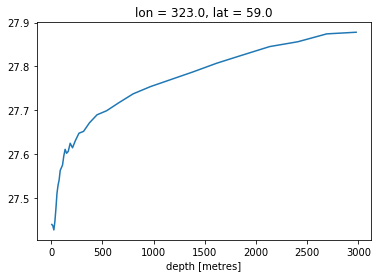

In [6]:
# Finally we compute the potential in-situ density
# First we define the associated function
def compute(absso, bigthetao, ref_pressure):
    """
    Computes the potential density in-situ.

    Parameters
    ----------
    absso: dask.array.core.Array
        Masked array containing the absolute salinity values (g/kg).
    bigthetao: dask.array.core.Array
        Masked array containing the conservative temperature values (degC).
    ref_pressure: float
        Reference pressure (dbar).

    Returns
    -------
    rho: dask.array.core.Array
        Masked array containing the potential density in-situ values (kg m-3).

    Note
    ----
    https://github.com/fabien-roquet/polyTEOS/blob/36b9aef6cd2755823b5d3a7349cfe64a6823a73e/polyTEOS10.py#L57

    """
    # reduced variables
    SAu = 40.*35.16504/35.
    CTu = 40.
    Zu = 1e4
    deltaS = 32.
    ss = np.sqrt((absso+deltaS)/SAu)
    tt = bigthetao / CTu
    pp = ref_pressure / Zu

    # vertical reference profile of density
    R00 = 4.6494977072e+01
    R01 = -5.2099962525e+00
    R02 = 2.2601900708e-01
    R03 = 6.4326772569e-02
    R04 = 1.5616995503e-02
    R05 = -1.7243708991e-03
    r0 = (((((R05*pp + R04)*pp + R03)*pp + R02)*pp + R01)*pp + R00)*pp

    # density anomaly
    R000 = 8.0189615746e+02
    R100 = 8.6672408165e+02
    R200 = -1.7864682637e+03
    R300 = 2.0375295546e+03
    R400 = -1.2849161071e+03
    R500 = 4.3227585684e+02
    R600 = -6.0579916612e+01
    R010 = 2.6010145068e+01
    R110 = -6.5281885265e+01
    R210 = 8.1770425108e+01
    R310 = -5.6888046321e+01
    R410 = 1.7681814114e+01
    R510 = -1.9193502195e+00
    R020 = -3.7074170417e+01
    R120 = 6.1548258127e+01
    R220 = -6.0362551501e+01
    R320 = 2.9130021253e+01
    R420 = -5.4723692739e+00
    R030 = 2.1661789529e+01
    R130 = -3.3449108469e+01
    R230 = 1.9717078466e+01
    R330 = -3.1742946532e+00
    R040 = -8.3627885467e+00
    R140 = 1.1311538584e+01
    R240 = -5.3563304045e+00
    R050 = 5.4048723791e-01
    R150 = 4.8169980163e-01
    R060 = -1.9083568888e-01
    R001 = 1.9681925209e+01
    R101 = -4.2549998214e+01
    R201 = 5.0774768218e+01
    R301 = -3.0938076334e+01
    R401 = 6.6051753097e+00
    R011 = -1.3336301113e+01
    R111 = -4.4870114575e+00
    R211 = 5.0042598061e+00
    R311 = -6.5399043664e-01
    R021 = 6.7080479603e+00
    R121 = 3.5063081279e+00
    R221 = -1.8795372996e+00
    R031 = -2.4649669534e+00
    R131 = -5.5077101279e-01
    R041 = 5.5927935970e-01
    R002 = 2.0660924175e+00
    R102 = -4.9527603989e+00
    R202 = 2.5019633244e+00
    R012 = 2.0564311499e+00
    R112 = -2.1311365518e-01
    R022 = -1.2419983026e+00
    R003 = -2.3342758797e-02
    R103 = -1.8507636718e-02
    R013 = 3.7969820455e-01

    rz3 = R013*tt + R103*ss + R003
    rz2 = (R022*tt+R112*ss+R012)*tt+(R202*ss+R102)*ss+R002
    rz1 = (((R041*tt+R131*ss+R031)*tt +
            (R221*ss+R121)*ss+R021)*tt +
           ((R311*ss+R211)*ss+R111)*ss+R011)*tt + \
        (((R401*ss+R301)*ss+R201)*ss+R101)*ss+R001
    rz0 = (((((R060*tt+R150*ss+R050)*tt +
              (R240*ss+R140)*ss+R040)*tt +
             ((R330*ss+R230)*ss+R130)*ss+R030)*tt +
            (((R420*ss+R320)*ss+R220)*ss+R120)*ss+R020)*tt +
           ((((R510*ss+R410)*ss+R310)*ss+R210)*ss+R110)*ss+R010)*tt + \
        (((((R600*ss+R500)*ss+R400)*ss+R300)*ss+R200)*ss+R100)*ss+R000
    r = ((rz3*pp + rz2)*pp + rz1)*pp + rz0

    # in-situ density
    return r + r0

# And we compute the in-situ density for the reference level 0  
obsD0=compute(obsSa,obsTc,0)
simD0=compute(simSa,simTc,0)

# Here we identify the last level before 10m
#simlevs=simSa.lev
#obslevs=obsSa.lev
#ilev0=0

#for ilev in range(len(simlevs)):   
# tlev = simlevs[ilev]
# if tlev<= 10: simlev10=ilev

#for ilev in range(len(obslevs)):   
# tlev = obslevs[ilev]
# if tlev<= 10: obslev10=ilev
#print(simlev10,simlevs[simlev10])
#print(obslev10,obslevs[obslev10])
(obsD0[:,149,322]-1000).plot()  # One grid point in the Labrador Sea

In [1]:
# Here we compute the MLD from the densit    # interpolate density data to 10m

def computemld(sigma0):
    """Compute mixed layer depth from so and thetao
    Parameters
    ----------
    sigma0 : xarray.DataArray for sigma0, dims must be time, space, depth (must be in metres)
    Returns
    -------
    mld: xarray.DataArray, dims of time, space
    
      This function developed by Dhruv Balweda, Andrew Pauling, Sarah Ragen, Lettie Roach
      
    """
    mld=sigma0
    
    # Here we identify the last level before 10m
    slevs=sigma0.lev
    ilev0=0

    for ilev in range(len(slevs)):   
     tlev = slevs[ilev]
     if tlev<= 10: slev10=ilev

    # And we take the 10m sigma0 as our surface reference
     surf_dens = sigma0[slev10]

    # We compute the density difference between surface and whole field
     dens_diff = sigma0-surf_dens
        
    
    # keep density differences exceeding threshold, discard other values
    dens_diff = dens_diff.where(dens_diff > 0.03)   ### The threshold should be 0.03!!

    # We determine the level at which the threshold is exceeded by the minimum margin
    cutoff_lev=dens_diff.lev.where(dens_diff==dens_diff.min(["lev"])).max(["lev"])        
    mld=cutoff_lev.rename("mld")

    
    # compute water depth
    # note: pressure.lev, cthetao.lev, and abs_salinity.lev are identical
#    test = sigma0.isel(time=0) + sigma0.lev
#    bottom_depth = (
#        pressure.lev.where(test == test.max(dim="lev"))
#        .max(dim="lev")
#        .rename("bottom_depth")
#    )  # units 'meters'

    # set MLD to water depth where MLD is NaN
#    mld = mld.where(~np.isnan(mld), bottom_depth)

    return mld
mld_tm=computemld(simD0)
#print(mld_tm[:,149,322])
#for i in range(0, len(mld_tm[:,149,322])):    
#    print(mld_tm[i,149,322])
#mld_tm[:,149,322].values
mld_clim=mld_tm[:,:].mean("time")
mld_clim[120:190,300:340].plot()

NameError: name 'simD0' is not defined